[445.0, 610.0]
[750.0, 875.0]
[1195.0, 1270.0]


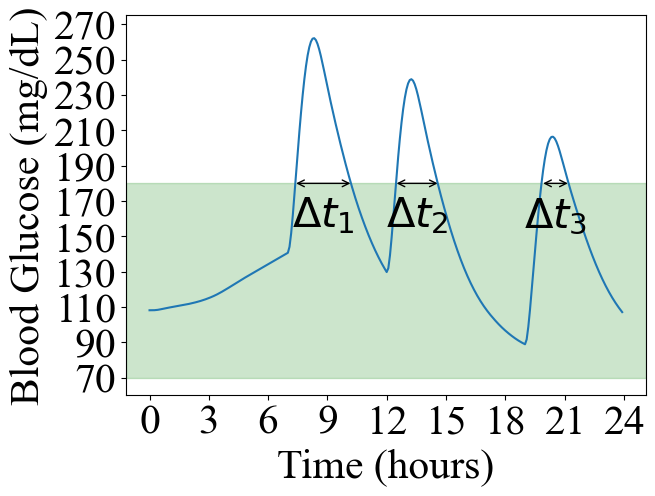

In [112]:
# AP case study

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Matplotlib global settings
plt.rcParams['font.size'] = 30
plt.rcParams['font.family'] = 'Times New Roman'

# Load the CSV files
data_file = './ap_violation_Data.csv'
time_file = './ap_violation_Time.csv'

data = pd.read_csv(data_file, header=None).iloc[:288, 0]
time = pd.read_csv(time_file, header=None).iloc[:288, 0]

# Convert time to hours
time_seconds = time.astype(int)
time_hours = time_seconds / 3600

# Plot the data
plt.figure(figsize=(6.4, 4.8))
plt.plot(time_hours, data, label='Glucose')

# X/Y ticks
plt.xticks(range(0, 25, 3))
plt.yticks(range(70, 271, 20))
plt.axhspan(70, 180, color="green", alpha=0.2, label="Target Range (70-180 mg/dL)")

# Identify segments where glucose > 180
above_180 = data > 180
segments = []
start = None
for i, val in enumerate(above_180):
    if val and start is None:
        start = i
    elif not val and start is not None:
        segments.append((start, i - 1))
        start = None
if start is not None:
    segments.append((start, len(data) - 1))
i=1
# Add double arrows for above-180 segments
for start, end in segments:
    x_start = time_hours[start]
    x_end = time_hours[end]
    y_arrow = 180
    duration = x_end - x_start
    # plt.axvline(x=x_start)
    # plt.axvline(x=x_end)
    print([x_start*60, x_end*60])
    arrow = FancyArrowPatch((x_start, y_arrow), (x_end, y_arrow),
                            arrowstyle='<->', color='black', mutation_scale=12, shrinkA=0, shrinkB=0)
    plt.gca().add_patch(arrow)

    plt.text((x_start + x_end) / 2, y_arrow - 30,
             f"$\Delta t_{i}$", ha='center', va='bottom', fontsize=30, color='black')
    i=i+1

# Labels and layout
plt.xlabel("Time (hours)")
plt.ylabel("Blood Glucose (mg/dL)")
# plt.legend()
# plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# plt.legend(fontsize=20)

# plt.xlim([0,48])

plt.ylim(top=275)
# Adjust layout and show the plot
plt.tight_layout(pad=0.02)
plt.savefig("AP_violation.jpg")
# plt.savefig("AP_violation.eps")
# plt.savefig("AP_violation.pdf")
plt.show()

In [113]:
from stl_rsi_monitor import *
import numpy as np, math

t1 = int(24*60/5)

signals = {"x": data}
phi1 = Not(
    C(0, t1-1, math.ceil(0.04*t1),
    AP("x", "<", 70)
     )
)

phi2 = Not(
    C(0,t1-1, math.ceil(0.25*t1)+1,
    AP("x", ">", 180)
     )
)

phi3 = C(0, t1-1, math.ceil(0.7*t1),
    And(AP("x", ">", 70),
       AP("x", "<", 180)
       )
)

phi4 = And(phi1,
          And(phi2, phi3))

up_1 = np.array([100]*len(signals["x"]), dtype="float")
up_2 = np.array([100]*len(signals["x"]), dtype="float")
up_3 = np.array([100]*len(signals["x"]), dtype="float")
up_4 = np.array([100]*len(signals["x"]), dtype="float")
down_1 = np.array([-100]*len(signals["x"]), dtype="float")
down_2 = np.array([-100]*len(signals["x"]), dtype="float")
down_3 = np.array([-100]*len(signals["x"]), dtype="float")
down_4 = np.array([-100]*len(signals["x"]), dtype="float")

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi1, signals, t=0, known=i)
    if(hi != INF):
        up_1[i] = hi
    if(lo != NINF):
        down_1[i] = lo

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi2, signals, t=0, known=i)
    if(hi != INF):
        up_2[i] = hi
    if(lo != NINF):
        down_2[i] = lo

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi3, signals, t=0, known=i)
    if(hi != INF):
        up_3[i] = hi
    if(lo != NINF):
        down_3[i] = lo

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi4, signals, t=0, known=i)
    if(hi != INF):
        up_4[i] = hi
    if(lo != NINF):
        down_4[i] = lo

    

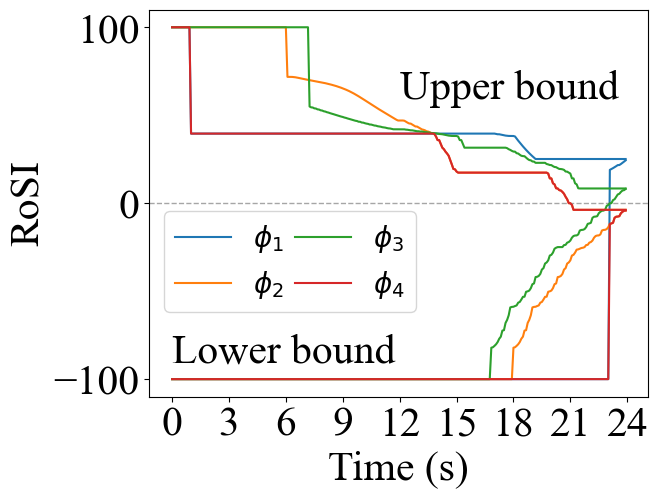

In [114]:

t=time_hours
plt.figure(figsize=(6.4, 4.8))
plt.plot(t, up_1, color='C0', label=r"$\phi_1$")
plt.plot(t, down_1, color='C0')
plt.plot(t, up_2, color='C1', label=r"$\phi_2$")
plt.plot(t, down_2, color='C1')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
# plt.axvline(x=21, color='gray', linestyle='--', linewidth=1, alpha=0.7)

plt.plot(t, up_3, color='C2', label=r"$\phi_3$")
plt.plot(t, down_3, color='C2')
plt.plot(t, up_4, color='C3', label=r"$\phi_4$")
plt.plot(t, down_4, color='C3')


plt.legend(fontsize=20, ncols=2, columnspacing=0.4,loc=(0.03,0.22))
# plt.yticks([-1, 0, 1, 2])
# plt.ylim([-1.05,2.05])
plt.xticks(range(0,25,3))
plt.xlabel("Time (s)")
plt.ylabel("RoSI")

plt.text(12, 65, "Upper bound",verticalalignment='center', fontsize=30, color='black')
plt.text(0, -85, "Lower bound",verticalalignment='center', fontsize=30, color='black')

plt.tight_layout(pad=0.02)
plt.savefig("ap_violation_rosi.jpg")
# plt.savefig("ap_violation_rosi.eps")

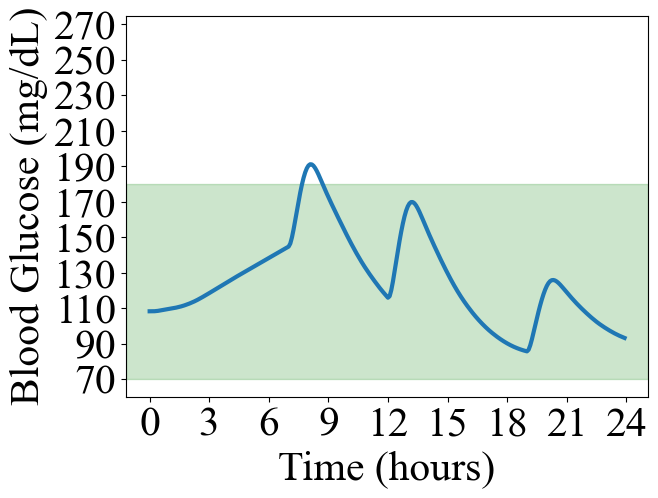

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Matplotlib global settings
plt.rcParams['font.size'] = 30
plt.rcParams['font.family'] = 'Times New Roman'

# Load the CSV files
data_file = './ap_satisfaction_Data.csv'  # Ensure correct file paths
time_file = './ap_satisfaction_Time.csv'

data = pd.read_csv(data_file, header=None)
time = pd.read_csv(time_file, header=None)

data = data.iloc[:288,0]
time = time.iloc[:288,0]

# Convert time to integer seconds and calculate elapsed hours
time_seconds = time.astype(int)
time_hours = time_seconds / 3600  # Convert seconds to hours

# Plot the data
# plt.figure(figsize=(10, 6))

plt.figure(figsize=(6.4, 4.8))

plt.plot(time_hours, data, linewidth=3)

# Set x-axis ticks to 0, 3, 6, ..., 48 hours
# plt.xticks(range(0, 49, 3))  # From 0 to 48 in steps of 3
plt.xticks(range(0, 25, 3))  # From 0 to 48 in steps of 3

# Set y-axis range and grid
plt.yticks(range(70, 271, 20))
plt.axhspan(70, 180, color="green", alpha=0.2, label="Target Range (70-180 mg/dL)")
# plt.grid(True, linestyle="--", alpha=0.6)

# Labels and legend
plt.xlabel("Time (hours)")
plt.ylabel("Blood Glucose (mg/dL)")
# plt.legend(fontsize=20)

# plt.xlim([0,48])
plt.ylim([60,275])
# Adjust layout and show the plot
plt.tight_layout(pad=0.02)
plt.savefig("AP_satisfaction.jpg")
# plt.savefig("AP_satisfaction.eps")
# plt.savefig("AP_satisfaction.pdf")
plt.show()

In [118]:
from stl_rsi_monitor import *
import numpy as np, math

t1 = int(24*60/5)

signals = {"x": data}
phi1 = Not(
    C(0, t1-1, math.ceil(0.04*t1),
    AP("x", "<", 70)
     )
)

phi2 = Not(
    C(0,t1-1, math.ceil(0.25*t1),
    AP("x", ">", 180)
     )
)

phi3 = C(0, t1-1, math.ceil(0.7*t1),
    And(AP("x", ">", 70),
       AP("x", "<", 180)
       )
)

phi4 = And(phi1,
          And(phi2, phi3))

up_1 = np.array([100]*len(signals["x"]), dtype="float")
up_2 = np.array([100]*len(signals["x"]), dtype="float")
up_3 = np.array([100]*len(signals["x"]), dtype="float")
up_4 = np.array([100]*len(signals["x"]), dtype="float")
down_1 = np.array([-100]*len(signals["x"]), dtype="float")
down_2 = np.array([-100]*len(signals["x"]), dtype="float")
down_3 = np.array([-100]*len(signals["x"]), dtype="float")
down_4 = np.array([-100]*len(signals["x"]), dtype="float")

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi1, signals, t=0, known=i)
    if(hi != INF):
        up_1[i] = hi
    if(lo != NINF):
        down_1[i] = lo

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi2, signals, t=0, known=i)
    if(hi != INF):
        up_2[i] = hi
    if(lo != NINF):
        down_2[i] = lo

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi3, signals, t=0, known=i)
    if(hi != INF):
        up_3[i] = hi
    if(lo != NINF):
        down_3[i] = lo

for i in range(len(signals["x"])):
    lo, hi = monitor_rsi(phi4, signals, t=0, known=i)
    if(hi != INF):
        up_4[i] = hi
    if(lo != NINF):
        down_4[i] = lo

    

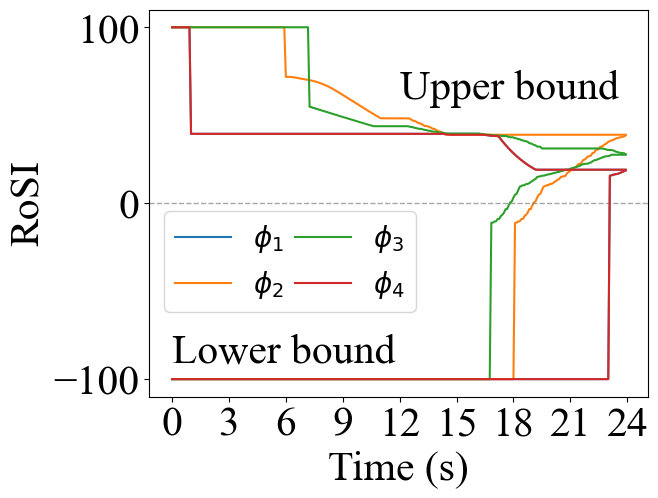

In [119]:
t = time_hours
plt.figure(figsize=(6.4, 4.8))
plt.plot(t, up_1, color='C0', label=r"$\phi_1$")
plt.plot(t, down_1, color='C0')
plt.plot(t, up_2, color='C1', label=r"$\phi_2$")
plt.plot(t, down_2, color='C1')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
# plt.axhline(y=-100, color='gray', linestyle='--', linewidth=1, alpha=0.7)

plt.plot(t, up_3, color='C2', label=r"$\phi_3$")
plt.plot(t, down_3, color='C2')
plt.plot(t, up_4, color='C3', label=r"$\phi_4$")
plt.plot(t, down_4, color='C3')


plt.legend(fontsize=20, ncols=2, columnspacing=0.4,loc=(0.03,0.22))
# plt.yticks([-1, 0, 1, 2])
# plt.ylim([-1.05,2.05])
plt.xticks(range(0,25,3))
plt.xlabel("Time (s)")
plt.ylabel("RoSI")

plt.text(12, 65, "Upper bound",verticalalignment='center', fontsize=30, color='black')
plt.text(0, -85, "Lower bound",verticalalignment='center', fontsize=30, color='black')

plt.tight_layout(pad=0.02)
plt.savefig("ap_satisfaction_rosi.jpg")
# plt.savefig("ap_satisfaction_rosi.eps")

# Overhead test for 100 traces

In [132]:
int(0.04*t1)+1

12

In [166]:
import os
import csv
import numpy as np
import time
from stl_rsi_monitor import *
f = './AP_trace/'

t1 = int(24*60/5)

phi1 = Not(
    C(0, t1-1, math.ceil(0.04*t1),
    AP("x", "<", 70)
     )
)

phi2 = Not(
    C(0,t1-1, math.ceil(0.25*t1),
    AP("x", ">", 180)
     )
)

phi3 = C(0, t1-1, int(0.7*t1),
    And(AP("x", ">", 70),
       AP("x", "<", 180)
       )
)

phi4 = And(phi1,
          And(phi2, phi3))

phi5 = G(0, 36, phi4)

phi6 = G(0, 72, phi4)

t2 = int(12*60/5)

phi7_1 = phi1 = Not(
    C(0, t2-1, math.ceil(0.04*t2),
    AP("x", "<", 70)
     )
)

phi7_2 = Not(
    C(0,t2-1, math.ceil(0.25*t2)+1,
    AP("x", ">", 180)
     )
)

phi7_3 = C(0, t2-1, math.ceil(0.7*t2),
    And(AP("x", ">", 70),
       AP("x", "<", 180)
       )
)

phi7_4 =And(phi7_1,
          And(phi7_2, phi7_3))

phi7 = G(0, 36, phi7_4)

In [126]:
import os 

e1 = []
e11= []
t11 = []


hor = 288
for j in os.listdir(f):
    trace = []
    
    if(j.split('.')[-1]=='csv'):
        
        # phi1_up = np.array([1000]*c_hor, dtype="float")
        # phi1_down = np.array([-1000]*c_hor, dtype="float")
        
        num = j.split('.')[0].split('-')[1]

        with open(f+j) as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            next(data_reader)
            for row in data_reader:
                
                trace.append(float(row[1]))

        signals = {"x": trace}
        begin = time.perf_counter()
        for i in range(len(trace)):

            lo, hi = monitor_rsi(phi1, signals, t=0, known=i+1)
            
            if(i==hor-1):
                break
            
            
            if(hi<0 or lo>0):
                e1.append(num)
                e11.append(i)
                break

        end = time.perf_counter()
        t11.append(end-begin)
        

In [129]:
import os 

e2 = []
e22 = []
t22 = []


hor = 288
for j in os.listdir(f):
    trace = []
    
    if(j.split('.')[-1]=='csv'):
        
        num = j.split('.')[0].split('-')[1]

        with open(f+j) as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            next(data_reader)
            for row in data_reader:
                
                trace.append(float(row[1]))

        signals = {"x": trace}
        begin = time.perf_counter()
        for i in range(len(trace)):

            lo, hi = monitor_rsi(phi2, signals, t=0, known=i+1)
            
            if(i==hor-1):
                break
            
            
            if(hi<0 or lo>0):
                e2.append(num)
                e22.append(i)
                break

        end = time.perf_counter()
        t22.append(end-begin)
        

In [167]:
import os 

e3 = []
e33 = []
t33 = []


hor = 288
for j in os.listdir(f):
    trace = []
    
    if(j.split('.')[-1]=='csv'):
        
        num = j.split('.')[0].split('-')[1]

        with open(f+j) as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            next(data_reader)
            for row in data_reader:
                
                trace.append(float(row[1]))

        signals = {"x": trace}
        begin = time.perf_counter()
        for i in range(len(trace)):

            lo, hi = monitor_rsi(phi3, signals, t=0, known=i+1)
            
            if(i==hor-1):
                break
            
            
            if(hi<0 or lo>0):
                e3.append(num)
                e33.append(i)
                break

        end = time.perf_counter()
        t33.append(end-begin)
        

In [139]:
import os 

e4 = []
e44 = []
t44 = []


hor = 288
for j in os.listdir(f):
    trace = []
    
    if(j.split('.')[-1]=='csv'):
        
        num = j.split('.')[0].split('-')[1]

        with open(f+j) as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            next(data_reader)
            for row in data_reader:
                
                trace.append(float(row[1]))

        signals = {"x": trace}
        begin = time.perf_counter()
        for i in range(len(trace)):

            lo, hi = monitor_rsi(phi4, signals, t=0, known=i+1)
            
            if(i==hor-1):
                break
            
            
            if(hi<0 or lo>0):
                e4.append(num)
                e44.append(i)
                break

        end = time.perf_counter()
        t44.append(end-begin)
        

In [141]:
import os 

e5 = []
e55 = []
t55 = []


hor = 288+36
for j in os.listdir(f):
    trace = []
    
    if(j.split('.')[-1]=='csv'):
        
        num = j.split('.')[0].split('-')[1]

        with open(f+j) as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            next(data_reader)
            for row in data_reader:
                
                trace.append(float(row[1]))

        signals = {"x": trace}
        begin = time.perf_counter()
        for i in range(len(trace)):

            lo, hi = monitor_rsi(phi5, signals, t=0, known=i+1)
            
            if(i==hor-1):
                break
            
            
            if(hi<0 or lo>0):
                e5.append(num)
                e55.append(i)
                break

        end = time.perf_counter()
        t55.append(end-begin)
        

In [146]:
import os 

e6 = []
e66 = []
t66 = []


hor = 288+72
for j in os.listdir(f):
    trace = []
    
    if(j.split('.')[-1]=='csv'):
        
        num = j.split('.')[0].split('-')[1]

        with open(f+j) as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            next(data_reader)
            for row in data_reader:
                
                trace.append(float(row[1]))

        signals = {"x": trace}
        begin = time.perf_counter()
        for i in range(len(trace)):

            lo, hi = monitor_rsi(phi6, signals, t=0, known=i+1)
            
            if(i==hor-1):
                break
            
            
            if(hi<0 or lo>0):
                e6.append(num)
                e66.append(i)
                break

        end = time.perf_counter()
        t66.append(end-begin)
        

In [162]:
import os 

e7 = []
e77 = []
t77 = []


hor = 144+36
for j in os.listdir(f):
    trace = []
    
    if(j.split('.')[-1]=='csv'):
        
        num = j.split('.')[0].split('-')[1]

        with open(f+j) as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            next(data_reader)
            for row in data_reader:
                
                trace.append(float(row[1]))

        signals = {"x": trace}
        begin = time.perf_counter()
        for i in range(len(trace)):

            lo, hi = monitor_rsi(phi7, signals, t=0, known=i+1)
            
            if(i==hor-1):
                break
            
            
            if(hi<0 or lo>0):
                e7.append(num)
                e77.append(i)
                break

        end = time.perf_counter()
        t77.append(end-begin)
        

In [169]:
print("Algorithm overheads")
print(sum(t11))
print(sum(t22))
print(sum(t33))
print(sum(t44))
print(sum(t55))
print(sum(t66))
print(sum(t77))

Algorithm overheads
77.57406149990857
77.11962520098314
73.21021650079638
243.742411600193
275.32343260059133
299.05550979985856
148.72431769920513
